# Simulating custom pulses

### Imports and settings

In [1]:
import sys

sys.path.append("../")
import pulse_simulator as ps

In [2]:
import numpy as np
from scipy import integrate

import csv
import functools
import qiskit as qk
import qiskit_dynamics as qk_d
import qiskit.quantum_info as qk_qi
import qiskit.providers.fake_provider as qk_fp
from qiskit.circuit.library import XGate, SXGate

/home/andy/.cache/pypoetry/virtualenvs/pulse-simulator-0UjnMsVt-py3.10/lib/python3.10/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [3]:
import matplotlib.pyplot as plt

In [4]:
# configure jax to use 64 bit mode
import jax

jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")

# set default backend
qk_d.array.Array.set_default_backend("jax")
qk_d.array.Array.default_backend()

'jax'

In [5]:
backend = qk_fp.FakeManila()
units = 1e9
GHz = 1 / units
ns = units

dt = backend.configuration().dt * ns
n_steps = 50
duration = n_steps * dt  # \approx 10 ns
dt, duration

(0.2222222222222222, 11.11111111111111)

### Retrieve saved pulses

In [14]:
file_name = "../pico-pulses/saved-pulses-2023-12-13/a_single_qubit_gateset_R1e-3.csv"
gates = []

saved_dt = 2/9

with open(file_name) as file:
    reader = csv.reader(file)
    for row in reader:
        gates.append([float(x) for x in row])

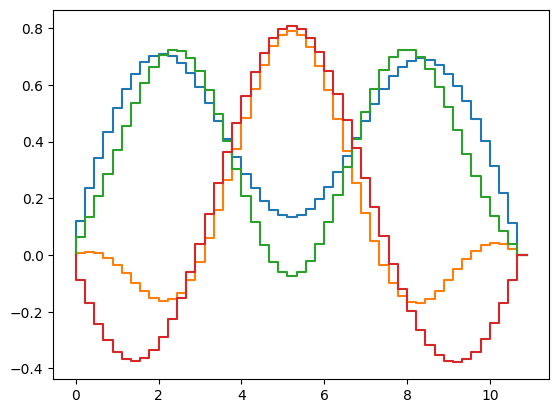

In [15]:
fig, ax = plt.subplots()
original_ts = np.arange(0, 50 * saved_dt, saved_dt)
for gate in gates:
    ax.step(original_ts, gate)

### Construct a solver

In [11]:
registers = [0]
config_vars = ps.backend_simulation_vars(backend, rabi=True, units=units)

H_rx = functools.partial(
    ps.rx_model,
    registers=registers,
    backend=backend,
    variables=config_vars,
    rotating_frame=False,
)

Hs_control = []
Hs_channels = []
for qubit in range(1):
    Hj_drift, Hjs_control, Hjs_channel = H_rx(qubit)
    Hs_control += Hjs_control
    Hs_channels += Hjs_channel


solver = qk_d.Solver(
    static_hamiltonian=None,
    hamiltonian_operators=Hs_control,
    static_dissipators=None,
    rotating_frame=None,
    rwa_cutoff_freq=None,
    hamiltonian_channels=Hs_channels,
    channel_carrier_freqs={ch: 0.0 for ch in Hs_channels},
    dt=dt,
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [16]:
def get_pulse_unitary(pulse_array, duration, dt, solver, expected=None):
    duration = duration * dt

    # rescale pulse if needed
    if expected is None:
        expected = integrate.simpson(pulse_array, dx=saved_dt)  # WARNING: Global
    normalization = integrate.simpson(pulse_array, dx=dt) / expected
    pulse_array = pulse_array / normalization

    # construct pulse and pulse moment
    pulse = qk.pulse.Waveform(pulse_array, limit_amplitude=False)
    with qk.pulse.build() as pulse_moment:
        channel = qk.pulse.DriveChannel(0)
        qk.pulse.play(pulse, channel)

    U0 = ps.qiskit_identity_operator(1)
    solver.model.evaluation_mode = "dense"
    sol = solver.solve(
        t_span=[0.0, duration],
        y0=U0,
        signals=pulse_moment,
        max_dt=dt,
        t_eval=np.linspace(0, duration, int(duration / dt)),
        method="jax_expm",
        magnus_order=3,
    )
    
    return sol.y

In [17]:
igate = 2
out = get_pulse_unitary(gates[igate], n_steps, 0.2, solver)
np.save(f"qiskit_custom_sim_{igate}.npy", out)

In [18]:
len(out)

50

## Normalize to one and two rotations

In [20]:
expected_list = [XGate(), XGate(), SXGate(), SXGate()]

for i, gate in enumerate(gates):
    # print("Output unitary:")
    out = get_pulse_unitary(gate, n_steps, dt, solver)[-1]
    # print(np.round(out.data, 5))

    # print("Expected unitary:")
    expected = qk_qi.Operator(expected_list[i])
    # print(np.round(expected.data, 5))

    print("Fidelity: ", qk_qi.process_fidelity(expected, out, require_cp=False, require_tp=False))

Fidelity:  0.9564176991702871
Fidelity:  0.9941756249337452
Fidelity:  0.9702279602232889
Fidelity:  0.9989138810380312


In [ ]:
expected_list = [XGate(), XGate(), SXGate(), SXGate()]
expected_angle = [3 * np.pi / 2, np.pi / 2, 5 * np.pi / 4, np.pi / 4]

for i, gate in enumerate(gates):
    # print("Output unitary:")
    out = get_pulse_unitary(gate, n_steps, dt, expected=expected_angle[i])[-1]
    # print(np.round(out.data, 5))

    # print("Expected unitary:")
    expected = qk_qi.Operator(expected_list[i])
    # print(np.round(expected.data, 5))

    print("Fidelity: ", qk_qi.process_fidelity(expected, out, require_cp=False, require_tp=False))

## Normalize to one rotation

In [ ]:
expected_list = [XGate(), XGate(), SXGate(), SXGate()]
expected_angle = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]

for i, gate in enumerate(gates):
    # print("Output unitary:")
    out = get_pulse_unitary(gate, 50, solver, expected=expected_angle[i])[-1]
    # print(np.round(out.data, 5))

    # print("Expected unitary:")
    expected = qk_qi.Operator(expected_list[i])
    # print(np.round(expected.data, 5))

    print("Fidelity: ", qk_qi.process_fidelity(expected, out, require_cp=False, require_tp=False))